<a href="https://colab.research.google.com/github/aaubs/ds-master/blob/main/notebooks/M2-pol_tweets_workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tweet-preprocessor -q

# Installing Gensim and PyLDAvis
!pip install -qq -U gensim
!pip install -qq pyLDAvis

     |████████████████████████████████| 24.1 MB 5.3 MB/s 
     |████████████████████████████████| 1.7 MB 6.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done


In [2]:
# explainability (why did the model say it's hate speech)
!pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 6.9 MB/s 
     |████████████████████████████████| 133 kB 59.7 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=c31b9a40a895e284a27c56567775361f5e62f9ae4dd8e39fb6c23a4353903d3f
  Stored in directory: /root/.cache/pip/wheels/cc/3c/96/3ead31a8e6c20fc0f1a707fde2e05d49a80b1b4b30096573be
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.2 which is incompatible.


In [4]:
import pandas as pd
import numpy as np
import preprocessor as prepro # twitter prepro
import tqdm #progress bar

import spacy #spacy for quick language prepro
nlp = spacy.load('en_core_web_sm') #instantiating English module

# sampling, splitting
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split


# loading ML libraries
from sklearn.pipeline import make_pipeline #pipeline creation
from sklearn.feature_extraction.text import TfidfVectorizer #transforms text to sparse matrix
from sklearn.linear_model import LogisticRegression #Logit model
from sklearn.metrics import classification_report #that's self explanatory
from sklearn.decomposition import TruncatedSVD #dimensionality reduction
from xgboost import XGBClassifier

import altair as alt #viz

#explainability
import eli5
from eli5.lime import TextExplainer

# topic modeling

from gensim.corpora.dictionary import Dictionary # Import the dictionary builder
from gensim.models import LdaMulticore # we'll use the faster multicore version of LDA

# Import pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

%matplotlib inline
pyLDAvis.enable_notebook()

In [5]:
# prepro settings
prepro.set_options(prepro.OPT.URL, prepro.OPT.NUMBER, prepro.OPT.RESERVED, prepro.OPT.MENTION, prepro.OPT.SMILEY)

In [6]:
pol_tweets = pd.read_json('https://github.com/SDS-AAU/SDS-master/raw/master/M2/data/pol_tweets.gz')

In [7]:
print(pol_tweets.iloc[-1]['text'])
print(pol_tweets.iloc[-1]['labels'])

The President claims his administration is, "defending religious freedom." But just four days ago, he expanded his international travel ban targeting Muslim countries. #SOTU http://pbs.twimg.com/media/EP-z5XwXUAAaXo5.png
1


In [8]:
# write everything into one function that can be re-used later
def text_prepro(texts):
  """
  takes in a pandas series (1 column of a DF)
  removes twitter stuff
  lowercases, normalizes text
  """
  texts_clean = texts.map(lambda t: prepro.clean(t))
  texts_clean = texts_clean.str.replace('#','')

  clean_container = []

  pbar = tqdm.tqdm(total=len(texts_clean),position=0, leave=True)

  for text in nlp.pipe(texts_clean, disable=["tagger", "parser", "ner"]):

    txt = [token.lemma_.lower() for token in text 
          if token.is_alpha 
          and not token.is_stop 
          and not token.is_punct]

    clean_container.append(" ".join(txt))
    pbar.update(1)
  
  return clean_container

In [9]:
# apply all prepro-pipeline to texts
pol_tweets['text_clean'] = text_prepro(pol_tweets['text'])

  0%|          | 0/50000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
100%|██████████| 50000/50000 [02:32<00:00, 328.10it/s]


In [10]:
pol_tweets.labels.value_counts().reset_index()

,index,labels
0,1,31181
1,0,18819


In [11]:
# fixing sample imbalance
rus = RandomUnderSampler(random_state=42)
data_df_res, y_res = rus.fit_resample(pol_tweets, pol_tweets['labels'])

In [12]:
# Splitting the dataset into the Training set and Test set (since we have a new output variable)
X_train, X_test, y_train, y_test = train_test_split(pol_tweets['text_clean'], pol_tweets['labels'], test_size = 0.4, stratify=pol_tweets['labels'], random_state = 42)

In [13]:
#instantiate models and "bundle up as pipeline"

tfidf = TfidfVectorizer()
cls = LogisticRegression()

pipe = make_pipeline(tfidf, cls)

In [14]:
pipe.fit(X_train,y_train) # fit model

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('logisticregression', LogisticRegression())])

In [15]:
# evaluate model performance on training set

y_eval = pipe.predict(X_train)
report = classification_report(y_train, y_eval)
print(report)

              precision    recall  f1-score   support

           0       0.88      0.70      0.78     11291
           1       0.84      0.94      0.89     18709

    accuracy                           0.85     30000
   macro avg       0.86      0.82      0.83     30000
weighted avg       0.85      0.85      0.85     30000



In [16]:
# overall weights (works only for linear models)
eli5.show_weights(pipe, top=20, target_names=['Rep.','Dem.'])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [17]:
y_pred = pipe.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.76      0.57      0.65      7528
           1       0.78      0.89      0.83     12472

    accuracy                           0.77     20000
   macro avg       0.77      0.73      0.74     20000
weighted avg       0.77      0.77      0.76     20000



In [18]:
debate_tweets = pd.read_json('https://github.com/SDS-AAU/SDS-master/raw/master/M2/data/pres_debate_2020.gz')

In [19]:
debate_tweets

,id,conversation_id,created_at,date,timezone,place,tweet,language,hashtags,cashtags,...,nretweets,quote_url,search,near,geo,source,reply_to,translate,trans_src,trans_dest
0,1318944772183281664,1318944772183281664,2020-10-21 15:58:33,2020-10-21 15:58:33,0,,Still time to register: Students can join the ...,en,[presidentialdebate2020],[],...,2,,PresidentialDebate2020,,,,"{'user_id': None, 'username': None}",,,
1,1318938583122743296,1318938583122743296,2020-10-21 15:33:57,2020-10-21 15:33:57,0,,Be prepared for Trump to railroad Thursday’s d...,en,[presidentialdebate2020],[],...,0,https://twitter.com/donaldjtrumpjr/status/1318...,PresidentialDebate2020,,,,"{'user_id': None, 'username': None}",,,
2,1318932554897031168,1318932554897031168,2020-10-21 15:10:00,2020-10-21 15:10:00,0,,Join us tomorrow from 5-8pm as @michaelpleahy ...,en,[presidentialdebate2020],[],...,0,,PresidentialDebate2020,,,,"{'user_id': None, 'username': None}",,,
3,1318928783169245184,1318928783169245184,2020-10-21 14:55:01,2020-10-21 14:55:01,0,,Wanna bet #ProudBoys comes up #PresidentialDeb...,en,"[proudboys, presidentialdebate2020]",[],...,0,,PresidentialDebate2020,,,,"{'user_id': None, 'username': None}",,,
4,1318927150247018496,1318927150247018496,2020-10-21 14:48:31,2020-10-21 14:48:31,0,,RT College Tour @BelmontUniv was spotless. Gor...,en,"[musiccity, presidentialdebate2020]",[],...,0,,PresidentialDebate2020,,,,"{'user_id': None, 'username': None}",,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8806,1311705601597222912,1311705601597222912,2020-10-01 16:32:40,2020-10-01 16:32:40,0,,Check out my Gig on Fiverr: do email marketing...,en,"[october1st, worsttrumpever, thursdaythoughts,...",[],...,0,,PresidentialDebate2020,,,,"{'user_id': None, 'username': None}",,,
8807,1311705488531156992,1311705488531156992,2020-10-01 16:32:13,2020-10-01 16:32:13,0,,This was made in 2012! It’s exactly like what ...,en,"[democrats, republicans, presidentialdebate202...",[],...,0,https://twitter.com/JonnyEthco/status/13113395...,PresidentialDebate2020,,,,"{'user_id': None, 'username': None}",,,
8808,1311705196657958912,1311705196657958912,2020-10-01 16:31:03,2020-10-01 16:31:03,0,,How you finna lose two swing states with one q...,en,[presidentialdebate2020],[],...,0,,PresidentialDebate2020,,,,"{'user_id': None, 'username': None}",,,
8809,1311704929090891776,1311704929090891776,2020-10-01 16:30:00,2020-10-01 16:30:00,0,,"This morning on the @ArleneBynonShow, @gmacofg...",en,"[erinotoole, blanchet, houseofcommons, trudeau...",[],...,3,,PresidentialDebate2020,,,,"{'user_id': None, 'username': None}",,,


In [20]:
# apply all prepro-pipeline to texts
debate_tweets['text_clean'] = text_prepro(debate_tweets['tweet'])

  0%|          | 0/8811 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
100%|██████████| 8811/8811 [00:18<00:00, 486.98it/s]


In [21]:
debate_tweets['class_pred'] = pipe.predict(debate_tweets['text_clean'])

In [22]:
debate_tweets['dem_proba'] = pipe.predict_proba(debate_tweets['text_clean'])[:,1]

In [23]:
debate_tweets.sort_values(['dem_proba'], ascending=True)['tweet'][:10]

6201    @realDonaldTrump @MarkMeadows @senatemajldr @k...
1144    @CBSNews #PresidentialDebate2020 RIGGED SYSTEM...
6194    Make America great again!🇺🇲💫💫 @POTUS @realDona...
7280    Senate found Hunter Biden got $3.5 from Moscow...
5234    China for Biden  #PresidentialDebate2020 #Deba...
1754    #HillaryClinton #china #Communism #Shame on yo...
1247    #PresidentialDebate2020 it’s great to see @rea...
6344    You can’t stop a man who defeated the China vi...
1035    I can start marking all these Pro #Biden hasht...
8238    My relationship with China is just an idea ......
Name: tweet, dtype: object

In [24]:
debate_tweets.sort_values(['dem_proba'], ascending=False)

,id,conversation_id,created_at,date,timezone,place,tweet,language,hashtags,cashtags,...,near,geo,source,reply_to,translate,trans_src,trans_dest,text_clean,class_pred,dem_proba
344,1318602399183818752,1318601992072212480,2020-10-20 17:18:05,2020-10-20 17:18:05,0,,@mjfree @CNN #Trump Don't have to show up!!!!!...,en,"[trump, presidentialdebate2020]",[],...,,,,"{'user_id': '24113137', 'username': 'mjfree'}",,,,trump,1,0.998588
7989,1311839298111434752,1311839298111434752,2020-10-02 01:23:56,2020-10-02 01:23:56,0,,#Trump Mute him out Mute him out Mute him out...,en,"[trump, presidentialdebate2020]",[],...,,,,"{'user_id': None, 'username': None}",,,,trump mute mute mute,1,0.998588
298,1318634737032974336,1318634737032974336,2020-10-20 19:26:35,2020-10-20 19:26:35,0,,Trump can thank Trump for this one 👇#President...,en,[presidentialdebate2020],[],...,,,,"{'user_id': None, 'username': None}",,,,trump thank trump,1,0.996317
7467,1311947628737966080,1311947628737966080,2020-10-02 08:34:24,2020-10-02 08:34:24,0,,Fight for Trump ##Trupm #PresidentialDebate2...,en,"[trupm, presidentialdebate2020]",[],...,,,,"{'user_id': None, 'username': None}",,,,fight trump trupm,1,0.992267
1449,1316897487815323648,1316897487815323648,2020-10-16 00:23:22,2020-10-16 00:23:22,0,,The Me Me Me Show by Donald Trump. #Presidenti...,en,[presidentialdebate2020],[],...,,,,"{'user_id': None, 'username': None}",,,,donald trump,1,0.991731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5234,1314025236619198464,1314025236619198464,2020-10-08 02:10:04,2020-10-08 02:10:04,0,,China for Biden #PresidentialDebate2020 #Deba...,en,"[presidentialdebate2020, debates2020, biden202...",[],...,,,,"{'user_id': None, 'username': None}",,,,china biden vpdebate,0,0.032934
7280,1312043357930246144,1312043357930246144,2020-10-02 14:54:47,2020-10-02 14:54:47,0,,Senate found Hunter Biden got $3.5 from Moscow...,en,"[maga2020, trump2020nowmorethanever, president...",[],...,,,,"{'user_id': None, 'username': None}",,,,senate found hunter biden got moscow amp money...,0,0.032542
6194,1313709057279029248,1313709057279029248,2020-10-07 05:13:41,2020-10-07 05:13:41,0,,Make America great again!🇺🇲💫💫 @POTUS @realDona...,en,[presidentialdebate2020],[],...,,,,"{'user_id': None, 'username': None}",,,,america great,0,0.030214
1144,1317263843702300672,1317253994201436160,2020-10-17 00:39:08,2020-10-17 00:39:08,0,,@CBSNews #PresidentialDebate2020 RIGGED SYSTEM...,en,"[presidentialdebate2020, lyingjoebiden]",[],...,,,,"{'user_id': '15012486', 'username': 'CBSNews'}",,,,rigged system american people want topics de f...,0,0.023829


## Topic modellng - what do dem/rep tweets say?

you can try out the tweetopic library (it's rather new, developed by people from Århus Uni. and I'm not sure about it so far: https://centre-for-humanities-computing.github.io/tweetopic/using_tweetopic.pipeline.html)

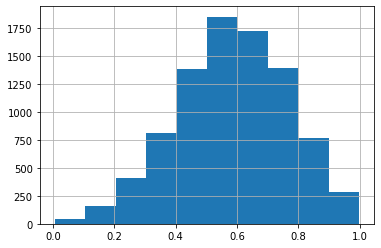

In [37]:
debate_tweets['dem_proba'].hist()

In [38]:
rep_tweets = debate_tweets[debate_tweets['dem_proba']<=0.2]

In [39]:
# preprocess texts (we need tokens)
tokens = []

for text in nlp.pipe(rep_tweets['text_clean'], disable=["ner"]):
  proj_tok = [token.lemma_.lower() for token in text 
              if token.pos_ in ['NOUN', 'PROPN', 'ADJ', 'ADV'] 
              and not token.is_stop
              and not token.is_punct] 
  tokens.append(proj_tok)

In [40]:
rep_tweets['tokens'] = tokens

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [41]:
# Create a Dictionary from the articles: dictionary
dictionary = Dictionary(rep_tweets['tokens'])
# filter out low-frequency / high-frequency stuff, also limit the vocabulary to max 1000 words
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)
# construct corpus using this dictionary
corpus = [dictionary.doc2bow(doc) for doc in rep_tweets['tokens']]

In [42]:
# Training the model
lda_model = LdaMulticore(corpus, id2word=dictionary, num_topics=5, workers = 4, passes=10)

In [43]:
# Let's try to visualize
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [44]:
 # Let's Visualize
pyLDAvis.display(lda_display)

**Tunint model N topics**

We can evaluate coherence from gensim.
Other measures are available within the Octis libary: https://github.com/mind-Lab/octis

Also consider:

https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0


In [45]:
from gensim.models import CoherenceModel

In [46]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=rep_tweets['tokens'], dictionary=dictionary, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  -11.431379358884298


### other models

Let's try LSI as an alternative approach - it is (kind of) the same as SVD.


In [47]:
# load models and utility
from gensim.models import LsiModel, TfidfModel
from gensim.matutils import corpus2dense

In [48]:
# fit tfidf weights
tfidf = TfidfModel(corpus)

In [49]:
# apply tfidf to data
corpus_tfidf = tfidf[corpus]

In [51]:
corpus[2]

[(1, 1), (3, 1), (5, 1), (6, 1), (7, 1)]

In [53]:
corpus_tfidf[2]

[(1, 0.26538829301598305),
 (3, 0.5558949347711835),
 (5, 0.5854556119119667),
 (6, 0.19375180871860104),
 (7, 0.49015491278254025)]

In [54]:
rep_tweets['tokens'].iloc[2]

['murtaugh',
 'biden',
 'answer',
 'chinese',
 'debate',
 'hunterslaptop',
 'quidprojoe',
 'presidentialdebate']

In [58]:
# train LSI model
lsi = LsiModel(corpus_tfidf, num_topics=10, id2word=dictionary)

In [59]:
lsi.print_topics()

[(0,
  '0.261*"maga" + 0.247*"arizona" + 0.246*"jobsreport" + 0.246*"leadright" + 0.246*"liz" + 0.246*"mesaaz" + 0.246*"confirmher" + 0.246*"chandler" + 0.246*"azvote" + 0.246*"fillthatseat"'),
 (1,
  '0.625*"biden" + 0.416*"debate" + 0.237*"china" + 0.192*"america" + 0.171*"democrats" + 0.158*"democrat" + 0.138*"god" + 0.130*"usa" + 0.127*"presidential" + 0.126*"trump"'),
 (2,
  '0.825*"china" + -0.396*"debate" + 0.242*"trump" + -0.114*"presidential" + 0.112*"americans" + 0.090*"poll" + 0.089*"usa" + -0.087*"moderator" + 0.086*"talk" + -0.086*"biden"'),
 (3,
  '-0.603*"god" + 0.564*"biden" + -0.264*"debate" + -0.243*"america" + -0.221*"president" + -0.195*"usa" + -0.120*"great" + 0.117*"democrats" + -0.114*"democrat" + -0.113*"good"'),
 (4,
  '-0.592*"debate" + 0.516*"god" + 0.291*"biden" + 0.290*"democrats" + -0.254*"china" + 0.172*"president" + -0.133*"democrat" + 0.132*"joebiden" + -0.130*"presidential" + 0.116*"usa"'),
 (5,
  '0.767*"democrat" + 0.290*"moderator" + -0.268*"debate"

In [61]:
# apply lsi (that's equivalent to SVD fit/transform in sklearn)
corpus_lsi = lsi[corpus_tfidf]

In [62]:
corpus_lsi[0]

[(0, 0.05098304688095354),
 (1, 0.1580096731383885),
 (2, -0.038668779334189295),
 (3, -0.11413962773292163),
 (4, -0.13320731934522226),
 (5, 0.7673715227005606),
 (6, -0.33062190138714637),
 (7, -0.15977979572854958),
 (8, -0.01089939746792537),
 (9, 0.17560037583944077)]

In [63]:
# turning it back into a matrix
lsi_matrix = corpus2dense(corpus_lsi, num_terms = 10)

In [67]:
# getting the top topic-index per doc.
np.argmax(lsi_matrix.T[0])

5